<a href="https://colab.research.google.com/github/AkiraMJ/-MEC-502_Topicos_MecSol-/blob/main/Atividade_3_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Placa 2D Elastoestática - Atividade 3.4

* Considere o problema de elasticidade para o plano de deformações do quadrado unitário, sujeito as condições de
contorno definidas

In [ ]:
# import requests
# from PIL import Image
# from io import BytesIO

# file_id = '1BxsAkNXfE68UKTIWvVBrezJqLebfI_u0'
# url = f'https://drive.google.com/uc?export=view&id={file_id}'

# response = requests.get(url)
# img = Image.open(BytesIO(response.content))

# new_size = (500, 500)  # (largura, altura) em pixels
# img_resized = img.resize(new_size)

# display(img_resized)
# #https://drive.google.com/file/d/1BxsAkNXfE68UKTIWvVBrezJqLebfI_u0/view?usp=drive_link

A placa 2D definida na figura é caracterizada como um cenário de um problema de Elasticidade Linear, em que o formalismo com simbolismo tensorial é dado por:

$$\begin{aligned}
\sigma_{ij,j} + f_i & = 0 \\
\sigma_{ij} & = \lambda \delta_{ij} \varepsilon_{kk} + 2\mu \varepsilon_{ij} \\
\varepsilon_{ij} & = \frac{1}{2} (u_{i,j} + u_{j,i})
\end{aligned}$$

Ao abrir essas equações temos para a **primeira equação**:
$$\frac{\partial \sigma_{xx}}{\partial x} + \frac{\partial \sigma_{xy}}{\partial y} + f_x= 0, \quad
\frac{\partial \sigma_{xy}}{\partial x} + \frac{\partial \sigma_{yy}}{\partial y} + f_y= 0,$$

para a **segunda:**
$$\sigma_{xx} = (\lambda + 2\mu)\epsilon_{xx} + \lambda\epsilon_{yy}, \quad
\sigma_{yy} = (\lambda + 2\mu)\epsilon_{yy} + \lambda\epsilon_{xx}, \quad
\sigma_{xy} =  2\mu\epsilon_{xy},$$

para a **última**
$$\epsilon_{xx} = \frac{\partial u_{x}}{\partial x}, \quad
\epsilon_{yy} = \frac{\partial u_{y}}{\partial y}, \quad
\epsilon_{xy} = \frac{1}{2}(\frac{\partial u_{x}}{\partial y} + \frac{\partial u_{y}}{\partial x}).$$


Nesse contexto, o domínio é definido por:
$$x \in [0, 1], \quad y \in [0, 1]$$

As forças de corpo são:
$$f_x = -2Q\lambda y (1-2x) e^{y^2} + \mu (-2Qy(1-2x)e^{y^2} + \pi^2 \sin(\pi y))$$

$$f_y = \lambda \left(-4Qy^2(-x^2+x)e^{y^2} -2Q(-x^2+x)e^{y^2}\right) + \mu \left(-8Qy^2(-x^2+x)e^{y^2} -4Q(-x^2+x)e^{y^2} + 2Qe^{y^2}\right)$$

As definições para os deslocamentos no contorno são:
$$u_x(x, 0) = u_x(x, 1) = 0,\\ u_y(0, y) = u_y(1, y) = u_y(x, 0) = 0,$$

e as condições de *traction*
$$\fbox{$\sigma_{yy} = 2e(\lambda + 2\mu)Q(x - x^2)$}$$


Os parâmetros ainda são definidos:
 $$\lambda = 1, \mu = 0.5,$ e $Q = 4$$

A solução exata:

$$\fbox{$u_x = \sin(\pi y)$}$$  
$$\fbox{$u_y = Q(x - x^2)(e^{y^2} - 1)$}$$

## Começo do Código

**instalacoes**

O SciANN não funciona com as versões atuais do TensorFlow e do Keras, portanto é necessário:
1. Desinstalar as duas bibliotecas (keras e tensorflow)
2. Reinstalar com uma versão anterior compatível (por exemplo a 2.12)
3. Instalar o SciANN

**rodar o bloco a seguir duas vezes**
1. Normalmente ocorre um pequeno erro e é necessário reiniciar o ambiente
2. Após reiniciar o ambiente, rode novamente esse bloco e as instalações serão completadas

In [ ]:
# ! pip uninstall -y keras tensorflow -q
# ! pip install tensorflow==2.12 -q
# ! pip install sciann -q
# ! pip install numpy==1.23.5 -q

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# import sciann as sn
# from sciann.utils.math import diff, sign, sin, sqrt
# from sciann import Functional, Parameter, Variable, SciModel, Data, Tie

## OBSERVAÇÕES SOBRE A SOLUÇÃO

Apesar do problema ser o mesmo que o discutido com o DeepXDE, a forma que vamos resolvê-lo é diferente:
* **Não vamos** definir **condições de contorno**
* **Vamos** nos basear quase que puramente nos **dados** da **solução analítica**  (pense isso como um teste de laboratório onde é possível saber algumas informações
  * Sabemos $u_x, u_y, \sigma_x, \sigma_y, \sigma_{xy}, f_x$ e $f_y$ em ''alguns'' pontos
* Esta é uma PINN hibrida

Além disso, vamos tentar garantir via rede que a física é obdecida levando em consideração:

$$\sigma = \mathbf{C} \varepsilon$$

ou de forma explicita:
$$ \begin{aligned}
\sigma_{xx} &= C_{11}\epsilon_x + C_{12}\epsilon_y \\
\sigma_{yy} &= C_{21}\epsilon_x + C_{22}\epsilon_y \\
\sigma_{xy} &= C_{33}\epsilon_{xy}
\end{aligned}
$$


**parametros do problema**

In [ ]:
# Parâmetros do material (Lame)
lmbd = 1
mu = 0.5
qload = 4

### Soluções exatas e equações do problema

In [ ]:
def load(xx):
    x, y = xx[0], xx[1]
    return (2 * np.exp * (lmbd + 2 * mu) * qload * (x - x**2))


**força de corpo $f_x$**
$$f_x = -2Q\lambda y (1-2x) e^{y^2} + \mu (-2Qy(1-2x)e^{y^2} + \pi^2 \sin(\pi y))$$


**Nota:** Aqui ocorre a troca o sinal das funções de corpo; é importante notar que na definição da PDE o sinal também está trocado, coincidindo com a teoria.

In [ ]:
def bodyfx(xx):
    x, y = xx[0], xx[1]
    frc = -1 * ((-2 * qload * lmbd * y * (1 - 2 * x) * np.exp(y**2)) +
              (mu * (-2 * qload * y * (1 - 2 * x) * np.exp(y**2) + np.pi**2 * np.sin(np.pi * y))))
    return frc


**força de corpo $f_y$**  
$$f_y = \lambda \left(-4Qy^2(-x^2+x)e^{y^2} -2Q(-x^2+x)e^{y^2}\right) + \mu \left(-8Qy^2(-x^2+x)e^{y^2} -4Q(-x^2+x)e^{y^2} + 2Qe^{y^2}\right)$$

In [ ]:
def bodyfy(xx):
    x, y = xx[0], xx[1]
    frc = -1 * (lmbd * (-4 * qload * y**2 * (-x**2 + x) * np.exp(y**2) - 2 * qload * (-x**2 + x) * np.exp(y**2)) \
              + mu * (-8 * qload * y**2 * (-x**2 + x) * np.exp(y**2) - 4 * qload * (-x**2 + x) * np.exp(y**2) + 2 * qload * np.exp(y**2)))
    return frc

**deslocamentos $u_x$ e $u_y$**
$$u_x = \sin(\pi y)$$  
$$u_y = Q(x - x^2)(e^{y^2} - 1)$$

In [ ]:
def dispx(xx):
    x, y = xx[0], xx[1]
    return np.sin(np.pi * y)
def dispy(xx):
    x, y = xx[0], xx[1]
    return qload * (x - x**2) * (np.exp(y**2) - 1)

**deformações**
$$\epsilon_{xx} = 0$$
$$\epsilon_{yy} = 2Qy(x - x^2)e^{y^2}$$
$$\epsilon_{xy} = \frac{1}{2}\left(\pi \cos(\pi y) + Q(1 - 2x)(e^{y^2} - 1)\right)$$

In [ ]:
def strainxx(xx):
    x, y = xx[0], xx[1]
    Q = qload
    #return -2*np.pi*np.sin(2*np.pi*x)*np.sin(np.pi*y)
    return 0
def strainyy(xx):
    x, y = xx[0], xx[1]
    Q = qload
    #return np.sin(np.pi*x)*Q*y**3
    return 2 * y * Q * (x - x**2) * np.exp(y**2)

def strainxy(xx):
    x, y = xx[0], xx[1]
    Q = qload
    #return 0.5*(np.pi*np.cos(2*np.pi*x)*np.cos(np.pi*y) + np.pi*np.cos(np.pi*x)*Q*y**4/4)
    return 0.5 * (np.pi * np.cos(np.pi * y) + Q * (1 - 2 * x) * (np.exp(y**2) - 1))

**tensoes**
$$\sigma_{xx} = (\lambda + 2\mu)\epsilon_{xx} + \lambda\epsilon_{yy}, \quad
\sigma_{yy} = (\lambda + 2\mu)\epsilon_{yy} + \lambda\epsilon_{xx}, \quad
\sigma_{xy} =  2\mu\epsilon_{xy}$$


In [ ]:
def stressxx(xx):
    Q= qload
    x, y = xx[0], xx[1]
    #return (lmbd+2*mu)*strainxx(xx) + lmbd*strainyy(xx)
    return lmbd * 2 * Q * y * (x - x**2) * np.exp(y**2)
def stressyy(xx):
    Q= qload
    x, y = xx[0], xx[1]
    #return (lmbd+2*mu)*strainyy(xx) + lmbd*strainxx(xx)
    return (lmbd + 2*mu) * 2 * Q * y * (x - x**2) * np.exp(y**2)
def stressxy(xx):
    Q= qload
    x, y = xx[0], xx[1]
    #return 2.0*mu*strainxy(xx)
    return mu * (np.pi * np.cos(np.pi * y) + Q * (1 - 2 * x) * (np.exp(y**2) - 1))

### Configuracoes para a rede

A única diferença aqui para o notebook do DeepXDE é a possibilidade de estruturar a rede de forma **tradicional** ou **paralela**, isso pode ser habilitado atribuindo respectivamente `False` ou `True` para o comando `independent_networks`


In [ ]:
# Configurações
config = {
    "layers": [50,50,50,50,50,50],  # Arquitetura da rede
    "activation": "tanh",
    "num_x": 50,                  # Pontos em x
    "num_y": 50,                  # Pontos em y
    "batch_size":32,
    "epochs": 500,
    "learning_rate": 0.001,
    "independent_networks": True,
    "dtype": "float64"
}

**criando o modelo**

COMANDO **`Tie`**
> Essa função funciona da seguinte forma; se temos a igualdade:
$$\sigma_{xx} = C_{11}\cdot \varepsilon_{xx} + C_{12} \cdot \varepsilon_{yy}$$  
logo queremos que nossa rede consiga satisfazer
$$\sigma_{xx} - C_{11}\cdot \varepsilon_{xx} - C_{12} \cdot \varepsilon_{yy} = 0$$  
A função Tie serve justamente para dizer ao modelo que um lado deve ser igual ao outro:  
$tie_1$ = `Tie`$(\sigma_{xx},C_{11}\cdot \varepsilon_{xx} + C_{12} \cdot \varepsilon_{yy})$  
e portanto usamos para Loss que $tie_1$ deve ser **zero**.


In [ ]:
# ==============================================
# Definindo o Modelo SciANN
# ==============================================
def create_model():
    # Variáveis de entrada: coordenadas
    x = Variable("x", dtype=config["dtype"])
    y = Variable("y", dtype=config["dtype"])

    ############################################################################
    # Variaveis de saida: deslocamentos e tensões
    # Aqui o condicional existe para poder estruturar a rede com FNN ou PFNN
    if config["independent_networks"]:
        Ux = Functional("Ux", [x, y], config["layers"], config["activation"])
        Uy = Functional("Uy", [x, y], config["layers"], config["activation"])
        Sxx = Functional("Sxx", [x, y], config["layers"], config["activation"])
        Syy = Functional("Syy", [x, y], config["layers"], config["activation"])
        Sxy = Functional("Sxy", [x, y], config["layers"], config["activation"])
    else:
        Ux, Uy, Sxx, Syy, Sxy = Functional(
            ["Ux", "Uy", "Sxx", "Syy", "Sxy"],
            [x, y],
            config["layers"],
            config["activation"]
        ).split()
    ############################################################################
    # Parâmetros de Lame
    lame1 = lmbd
    lame2 = mu

    # Relações constitutivas
    C11 = (2*lame2 + lame1)
    C12 = lame1
    C33 = 2*lame2

    # Deformações
    Exx = diff(Ux, x)
    Eyy = diff(Uy, y)
    Exy = (diff(Ux, y) + diff(Uy, x)) * 0.5

    # Restrições físicas
    c1 = Tie(Sxx, Exx*C11 + Eyy*C12)  # sxx = C11*exx + C12*eyy
    c2 = Tie(Syy, Eyy*C11 + Exx*C12)  # syy = C11*eyy + C12*exx
    c3 = Tie(Sxy, Exy*C33)            # sxy = 2mu*exy

    # Equações de equilíbrio (momentum_x e momentum_y)
    Lx = diff(Sxx, x) + diff(Sxy, y)  # dsxx/dx + dsxy/dy + fx = 0
    Ly = diff(Sxy, x) + diff(Syy, y)  # dsxy/dx + dsyy/dy + fy = 0

    # Valores obtidos pela rede
    d1 = Data(Ux)  # u(x,y)
    d2 = Data(Uy)  # v(x,y)
    d3 = Data(Sxx)  # sxx
    d4 = Data(Syy)  # syy
    d5 = Data(Sxy)  # sxy

    ############################################################################
    ########################### Criando o modelo ############################
    # Definimos quem são os dados de entreada: x, y
    # Definimos quem são os nossos alvos:
    #    Consideramos os proprios valores de saida da rede: d1, d2, d3, d4 e d5
    #    Consideremos as restricoes fisicas e de equilibrio: c1, c2, c3, Lx e Ly
    model = SciModel(
        inputs=[x, y],
        targets=[d1, d2, d3, d4, d5, c1, c2, c3, Lx, Ly],
        loss_func="mse",
        optimizer="adam"
    )
    return model, (Ux, Uy, Sxx, Syy, Sxy)

Esse formato do `return` explicitando as componentes Ux, Uy etc é para facilitar na hora de acessar os resultados

In [ ]:
# Gerando o modelo
model, networks = create_model()
Ux, Uy, Sxx, Syy, Sxy = networks

**treinamento**

O formato do `input_data` é definido com o uso de alguns comandos menores:

* Criamos dois vetores um para x e outro para y, com formatos (1, Nx) e (1,Ny)
* Depois criamos uma malha com o `meshgrid`

Exemplo
```python
x = np.linspace(0, 1, 3)  # [0, 0.5, 1]
y = np.linspace(0, 1, 2)  # [0, 1]
X, Y = np.meshgrid(x, y)
```
Resultado
```text
X = [[0.  0.5 1. ],    Y = [[0. 0. 0.],
     [0.  0.5 1. ]]         [1. 1. 1.]]
```

O comando `flatten` vai achatar essas matrizes
```python
X.flatten()  # Saída: [0., 0.5, 1., 0., 0.5, 1.]
Y.flatten()  # Saída: [0., 0., 0., 1., 1., 1.]
```

In [ ]:
# Gerar dados de treinamento
xx = np.linspace(0, 1, config["num_x"])
yy = np.linspace(0, 1, config["num_y"])

X, Y = np.meshgrid(xx,yy)
input_data = [X.flatten()[:, None], Y.flatten()[:, None]]

# Dados de treinamento (valores exatos)
target_data = [
    dispx(input_data),     # Ux
    dispy(input_data),     # Uy
    stressxx(input_data),  # Sxx
    stressyy(input_data),  # Syy
    stressxy(input_data),  # Sxy
    'zeros',               # c1
    'zeros',               # c2
    'zeros',               # c3
    bodyfx(input_data),    # Lx
    bodyfy(input_data)     # Ly
]


Total samples: 2500 
Batch size: 32 
Total batches: 79 


Epoch 91: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 223: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 337: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 388: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 488: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.


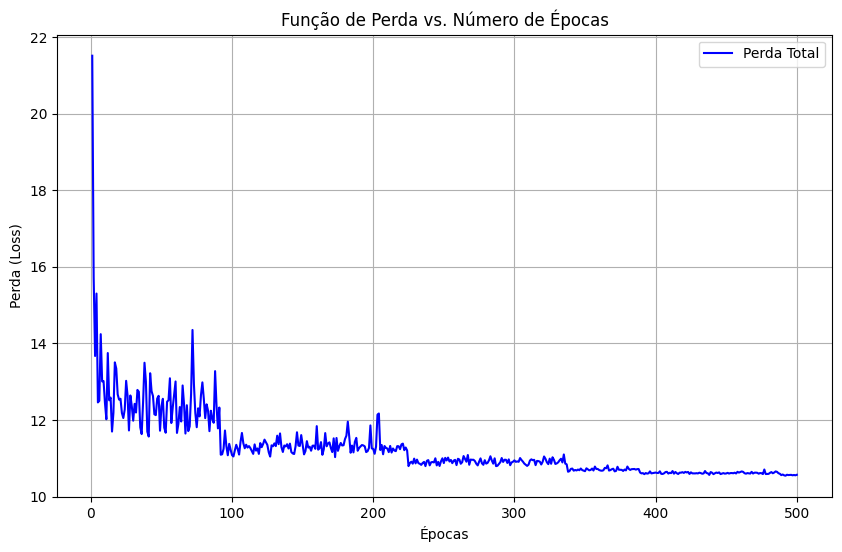

In [ ]:
# Treinar
# history = model.train(
#     input_data,
#     target_data,
#     epochs=config["epochs"],
#     batch_size=config["batch_size"],
#     learning_rate=config["learning_rate"],
#     verbose=1
# )

# Treinar
# >>>>>>>>>>>>>> INSERINDO PESOS AQUI <<<<<<<<<<<<<<
# Dicionário de pesos para a função de perda
weights = [
    np.ones_like(dispx(input_data)).ravel(),       # Ux  (d1)
    np.ones_like(dispy(input_data)).ravel(),       # Uy  (d2)
    np.ones_like(stressxx(input_data)).ravel(),    # Sxx (d3)
    100.0 * np.ones_like(stressyy(input_data)).ravel(),  # Syy (d4)
    100.0 * np.ones_like(stressxy(input_data)).ravel(),  # Sxy (d5)
    np.ones_like(dispx(input_data)).ravel(),       # tie-1 (c1)
    np.ones_like(dispx(input_data)).ravel(),       # tie-2 (c2)
    np.ones_like(dispx(input_data)).ravel(),       # tie-3 (c3)
    np.ones_like(dispx(input_data)).ravel(),       # diff-1 (Lx)
    np.ones_like(dispx(input_data)).ravel()        # diff-2 (Ly)
]

history = model.train(
    input_data,
    target_data,
    epochs=config["epochs"],
    batch_size=config["batch_size"],
    learning_rate=config["learning_rate"],
    verbose=0,
    weights=weights, # Passa o dicionário de pesos

)
# =============================================================================
# CÓDIGO PARA PLOTAR A FUNÇÃO DE PERDA
# =============================================================================

# Acesse o histórico de perdas
loss_values = history.history['loss']
epochs = range(1, len(loss_values) + 1)

# Crie o gráfico
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss_values, label='Perda Total', color='blue')
plt.title('Função de Perda vs. Número de Épocas')
plt.xlabel('Épocas')
plt.ylabel('Perda (Loss)')
plt.yscale('log') # Usar escala logarítmica para melhor visualização da descida
plt.grid(True)
plt.legend()
plt.show()

# Gráficos

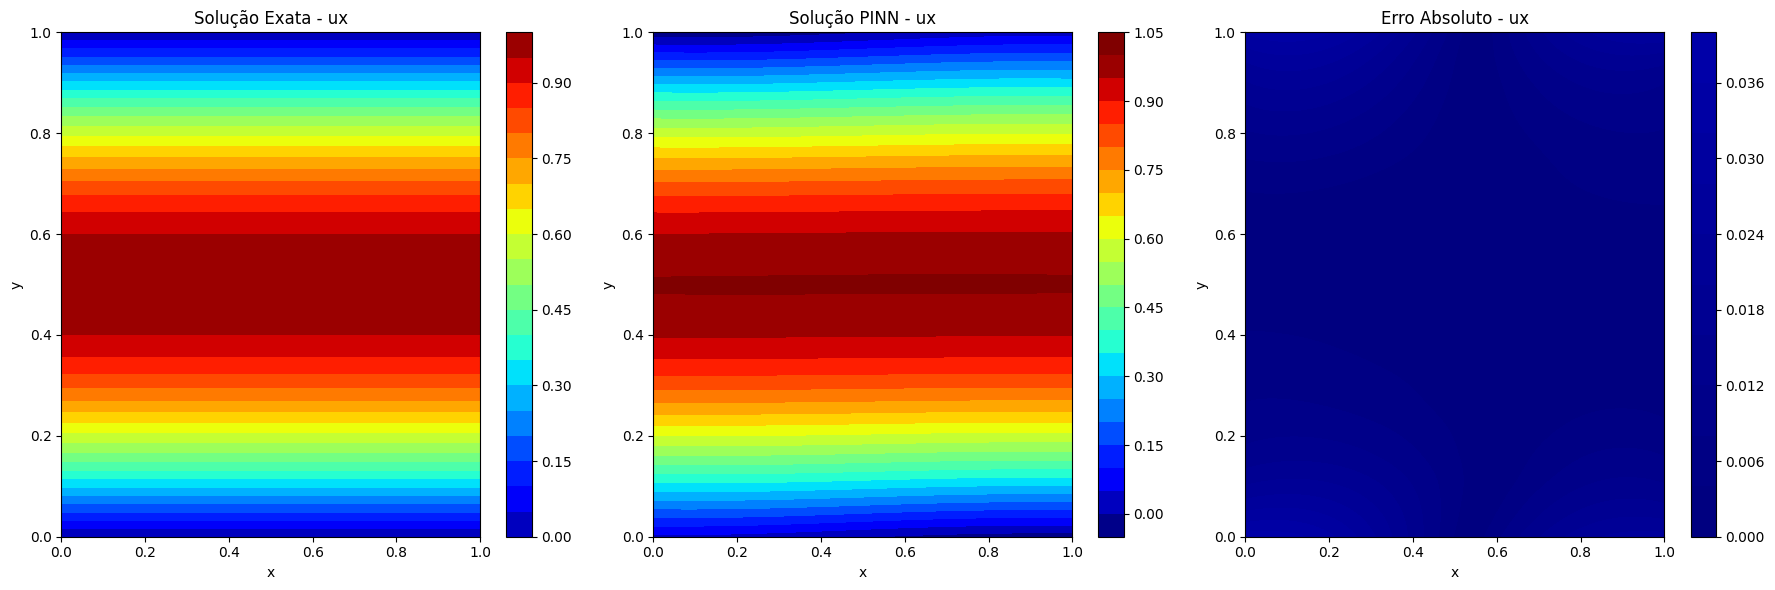

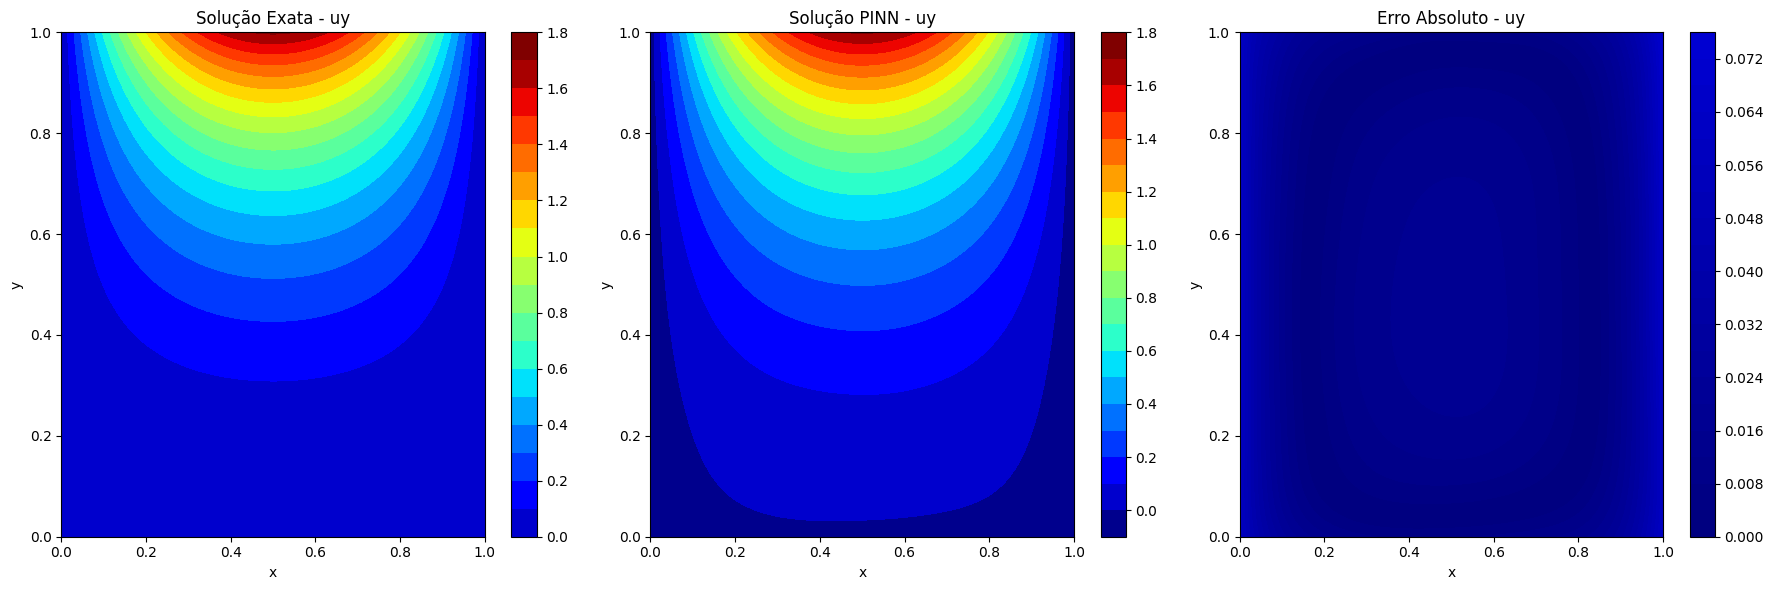

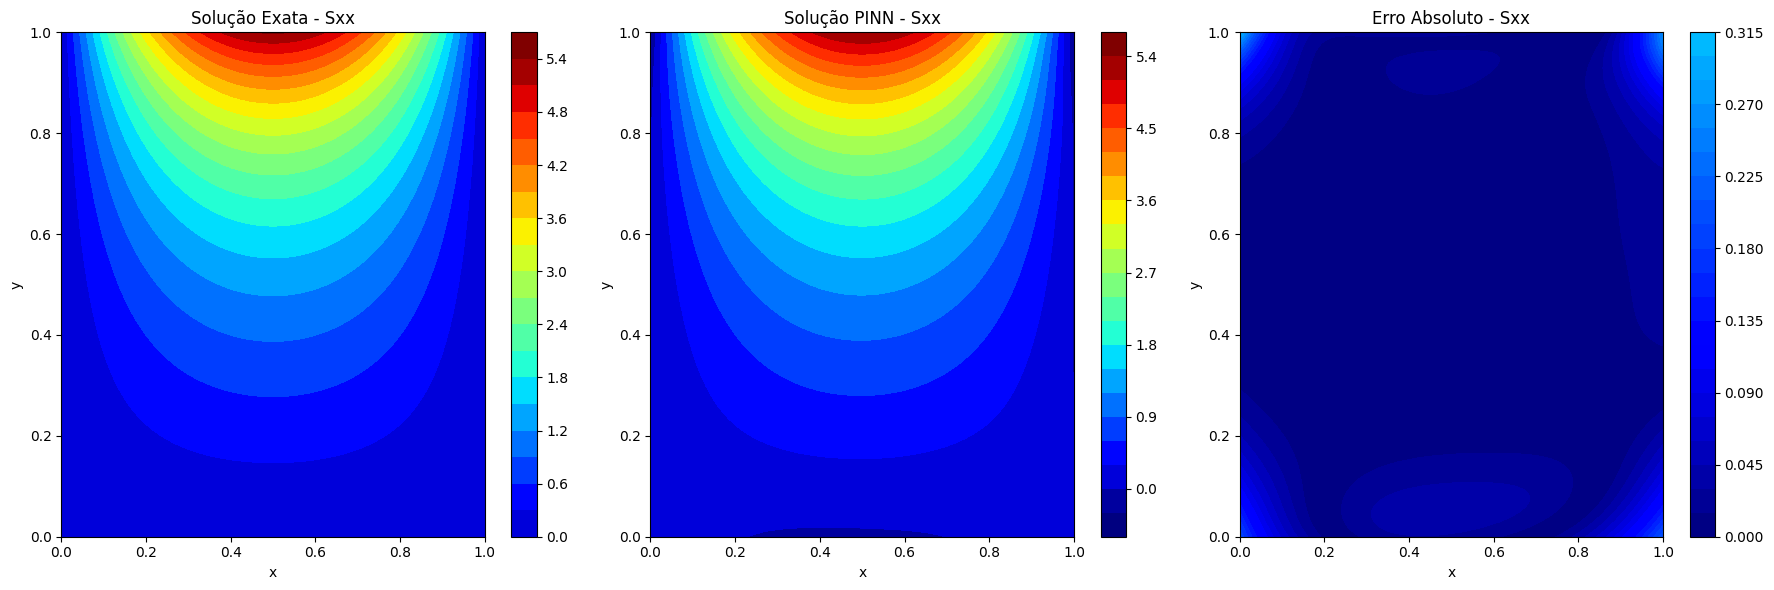

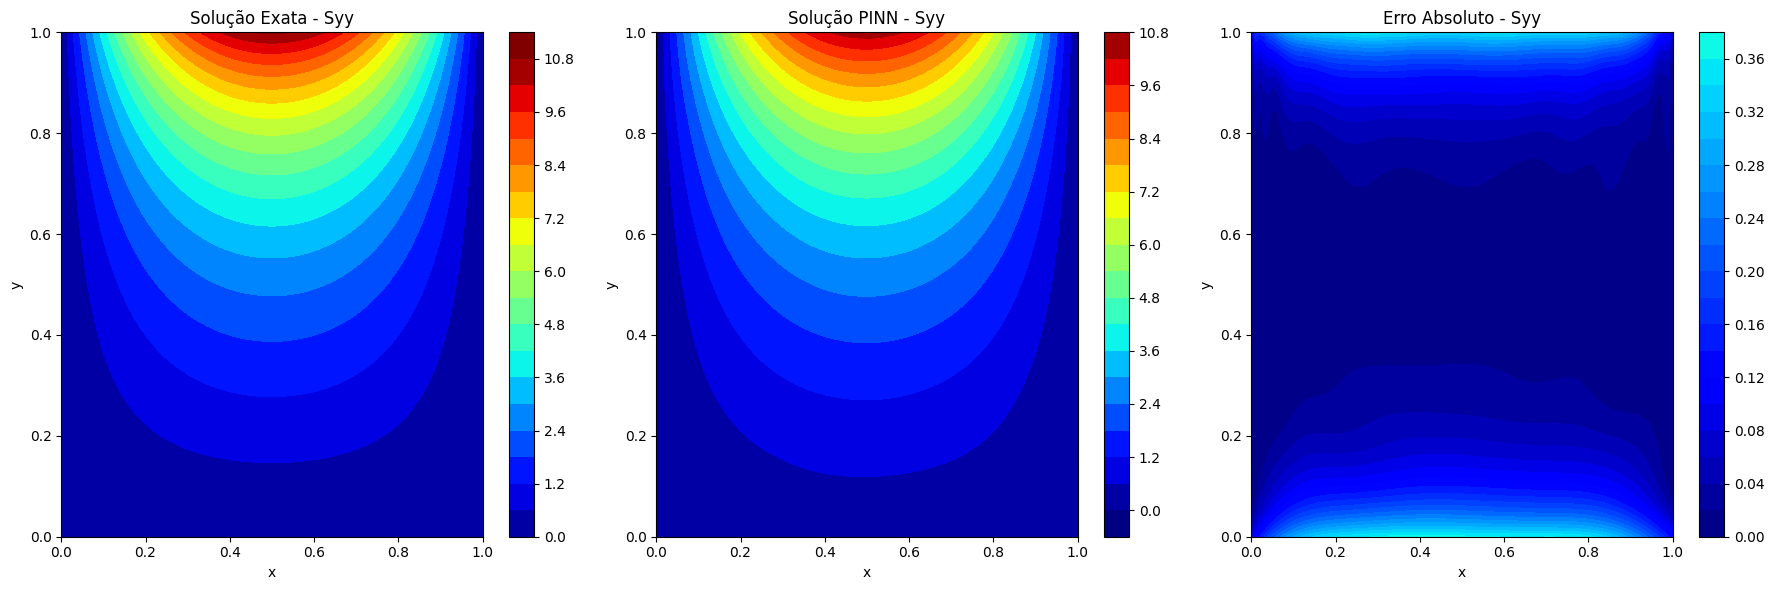

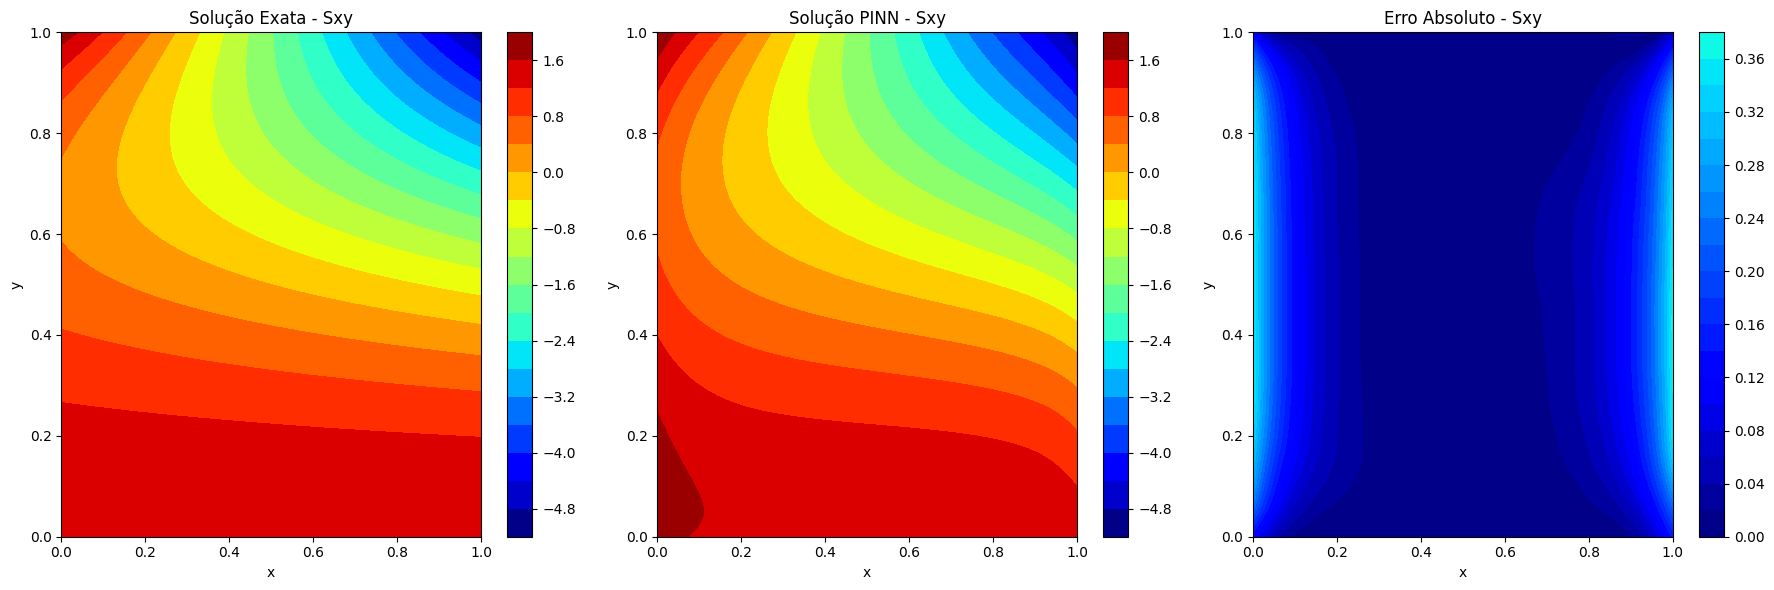

In [ ]:
# ===== Pós-processamento =====
# Gerar grade para plotagem
x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100)
X, Y = np.meshgrid(x, y)
input_plot = [X.flatten()[:, None], Y.flatten()[:, None]]

# Predições
Ux_pred = Ux.eval(model, input_plot)
Uy_pred = Uy.eval(model, input_plot)
Sxx_pred = Sxx.eval(model, input_plot)
Syy_pred = Syy.eval(model, input_plot)
Sxy_pred = Sxy.eval(model, input_plot)

# Valores verdadeiros
ux_true = dispx(input_plot)
uy_true = dispy(input_plot)
sx_true = stressxx(input_plot)
sy_true = stressyy(input_plot)
sxy_true = stressxy(input_plot)

exact_solution = np.hstack((ux_true, uy_true, sx_true, sy_true, sxy_true))
predicted_solution = np.hstack((Ux_pred, Uy_pred, Sxx_pred, Syy_pred, Sxy_pred))

# Nomes das variáveis para plotagem
variables = ["ux", "uy", "Sxx", "Syy", "Sxy"]
num_vars = len(variables)

# Criar figuras para cada variável
for i in range(num_vars):
    plt.figure(figsize=(18, 6))
    vmin = min(np.min(exact_solution[:, i]), np.min(predicted_solution[:, i]))
    vmax = max(np.max(exact_solution[:, i]), np.max(predicted_solution[:, i]))

    # Plot solução exata
    plt.subplot(1, 3, 1)
    exact = exact_solution[:, i].reshape(100, 100)
    im = plt.contourf(X, Y, exact, levels=20, cmap="jet", vmin=vmin, vmax=vmax)
    plt.colorbar(im)
    plt.title(f"Solução Exata - {variables[i]}")
    plt.xlabel("x")
    plt.ylabel("y")

    # Plot solução PINN
    plt.subplot(1, 3, 2)
    pred = predicted_solution[:, i].reshape(100, 100)
    im = plt.contourf(X, Y, pred, levels=20, cmap="jet", vmin=vmin, vmax=vmax)
    plt.colorbar(im)
    plt.title(f"Solução PINN - {variables[i]}")
    plt.xlabel("x")
    plt.ylabel("y")

    # Plot erro absoluto
    plt.subplot(1, 3, 3)
    #error = np.sqrt(((exact - pred)**2)/100)
    error = np.abs(exact - pred)
    im = plt.contourf(X, Y, error, levels=20, cmap="jet", vmin=0, vmax=1)
    plt.colorbar(im)
    plt.title(f"Erro Absoluto - {variables[i]}")
    plt.xlabel("x")
    plt.ylabel("y")

    plt.tight_layout()
    plt.show()



* A estrutura da rede utilizada ; [50,50,50,50,50,50]
* Quantidade de pontos de colocação - 2500 (50x50)
* Função de ativação - Tanh
* Otimizador - Adam
* número de épocas - 200
* taxa de aprendizagem - lr=0.0005


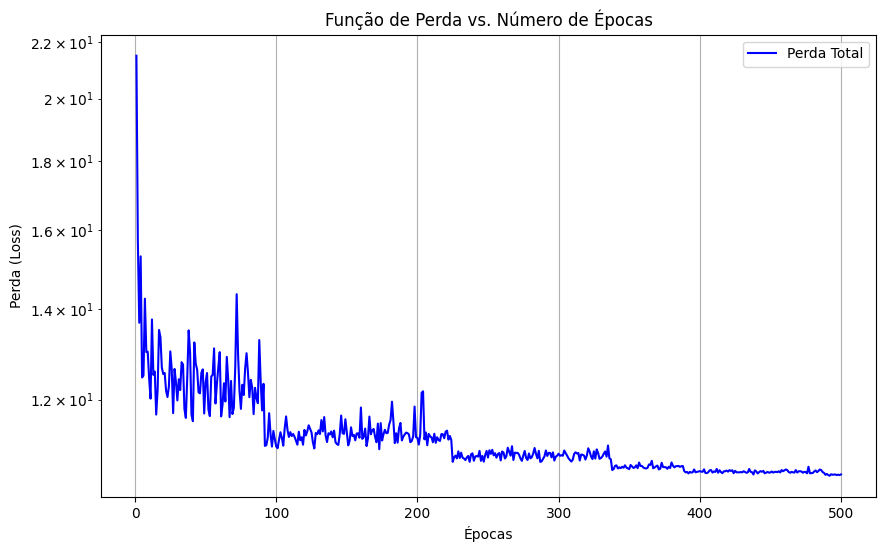

In [ ]:
# Acesse o histórico de perdas
loss_values = history.history['loss']
epochs = range(1, len(loss_values) + 1)

# Crie o gráfico
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss_values, label='Perda Total', color='blue')
plt.title('Função de Perda vs. Número de Épocas')
plt.xlabel('Épocas')
plt.ylabel('Perda (Loss)')
plt.yscale('log') # Usar escala logarítmica para melhor visualização da descida
plt.grid(True)
plt.legend()
plt.show()